### Description
This notebook is my first job in time series and one of the firsts in data science.

The objective of this work is to understand how the Arima model behaves and then to approach more complex explorations.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime
from pylab import rcParams
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Importing Datas

In [2]:
df_train = pd.read_csv("./Data/train.csv", parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv("./Data/test.csv", parse_dates=['date'], index_col=['date'])
df = pd.concat([df_train,df_test],sort=True)

In [3]:
df.head()

,id,item,sales,store
date,,,,
2013-01-01,NaN,1,13.0,1
2013-01-02,NaN,1,11.0,1
2013-01-03,NaN,1,14.0,1
2013-01-04,NaN,1,13.0,1
2013-01-05,NaN,1,10.0,1


In [4]:
df.dtypes

id       float64
item       int64
sales    float64
store      int64
dtype: object

# Analyzing the data

In [5]:
df['store'].value_counts()

10    95800
9     95800
8     95800
7     95800
6     95800
5     95800
4     95800
3     95800
2     95800
1     95800
Name: store, dtype: int64

In [6]:
df['sales'].count()

913000

In [7]:
df.isnull().sum()

id       913000
item          0
sales     45000
store         0
dtype: int64

In [8]:
df = df.fillna(0)

# Ploting 

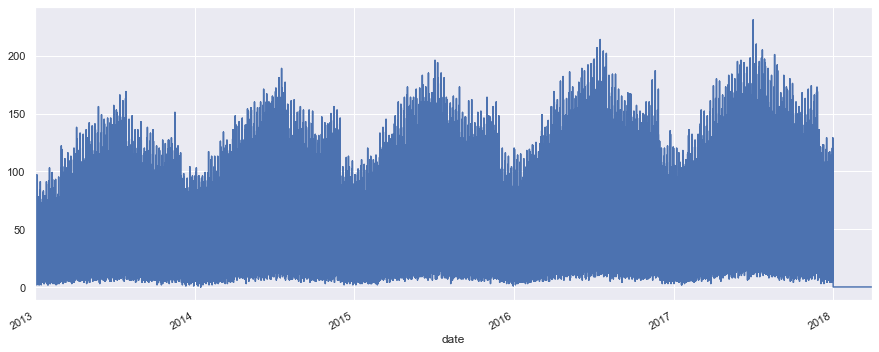

In [9]:
df.sales.plot(figsize=(15, 6))
plt.show()

# Ploting stores

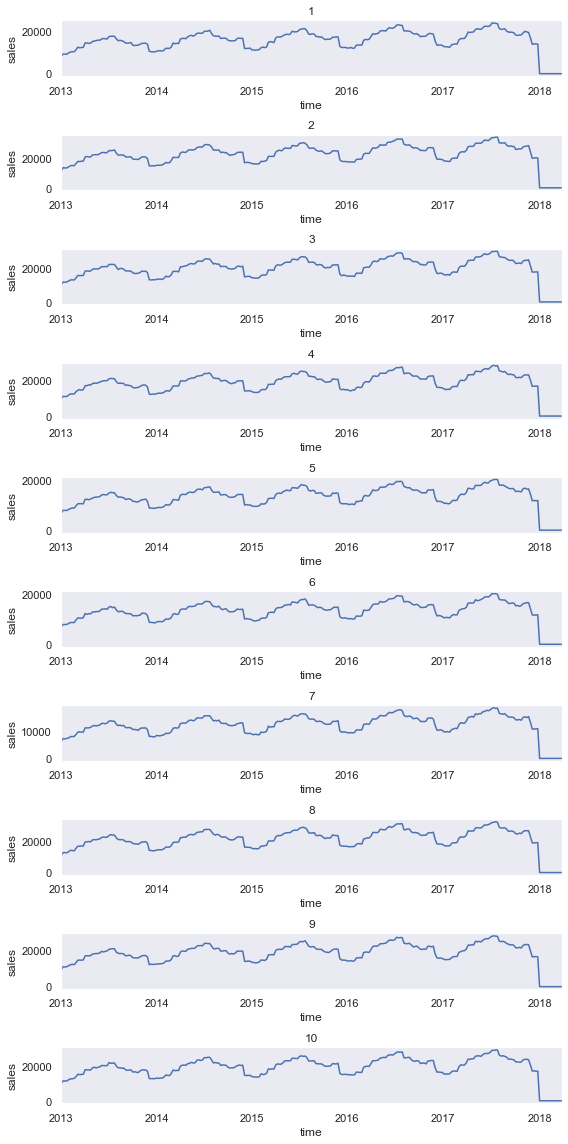

In [10]:
lojas = len(df['store'].unique())
fig, axes = plt.subplots(lojas, figsize=(8, 16))

for x in df['store'].unique():
    m = df.loc[df['store'] == x, 'sales'].resample('W').sum()
    ax = m.plot(title = x, ax=axes[x-1])
    ax.grid()   
    ax.set_xlabel('time')
    ax.set_ylabel('sales')
fig.tight_layout();

# Trend, Seasonality and Residuals

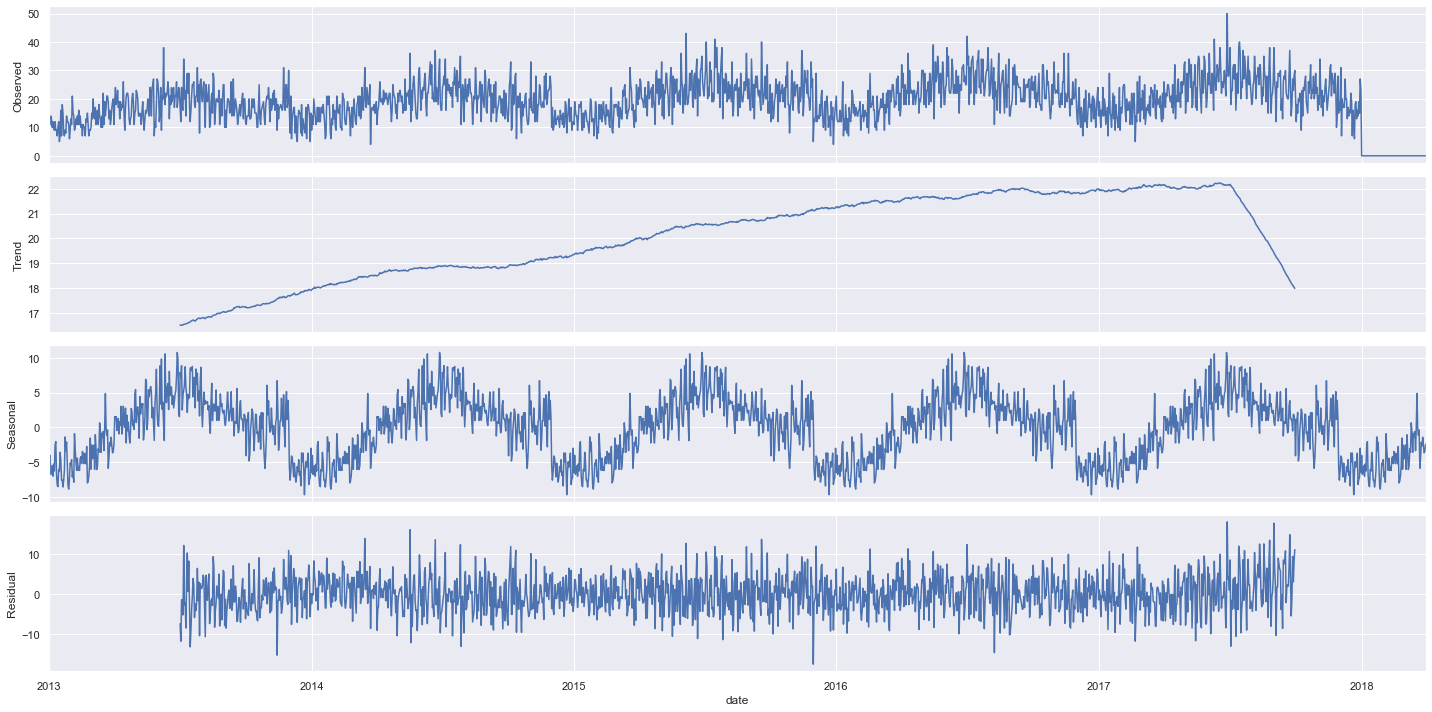

In [11]:
one_store = df[(df.item==1)&(df.store==1)].copy()
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(one_store.sales.dropna(), freq=365)
fig = decomposition.plot()
plt.show()

__Comentários:__

- __Obs__: There is a clear rhythm in sales with peaks of sales and low sales in the same periods of the observed years.
<br>
- __Trend__: increase in sales over the time series.
<br>
- __Seasonality__: instability and fall at the end, great progress in sales until the middle of the year.


# Test Stationarity 

In [12]:
def test_stationarity(timeseries):
    
 # rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

 #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False) 

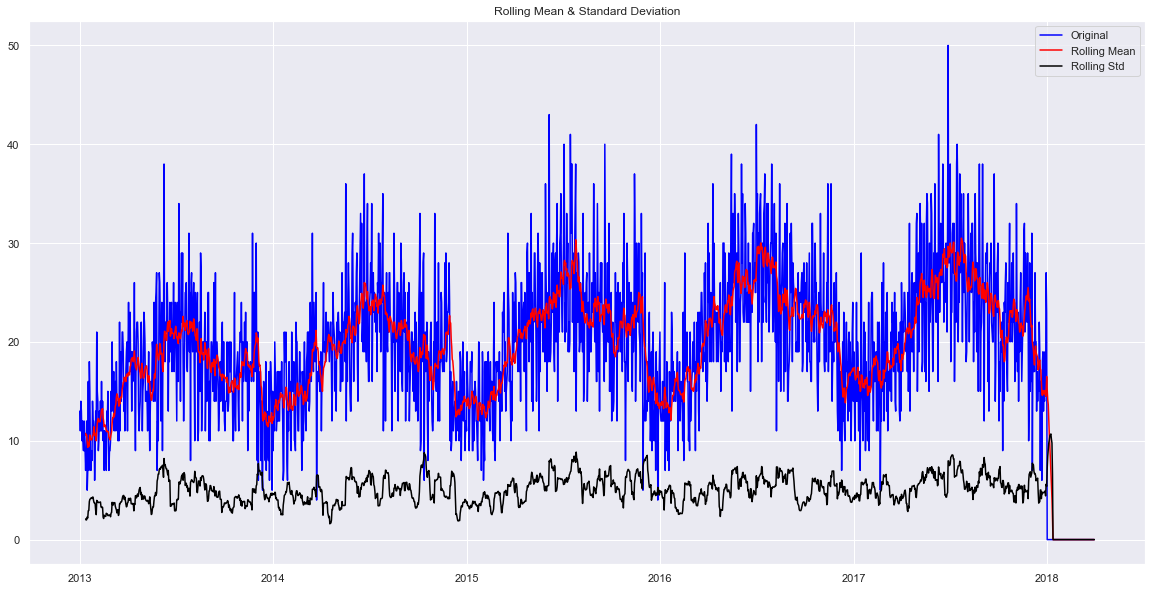

In [13]:
test_stationarity(one_store['sales'])

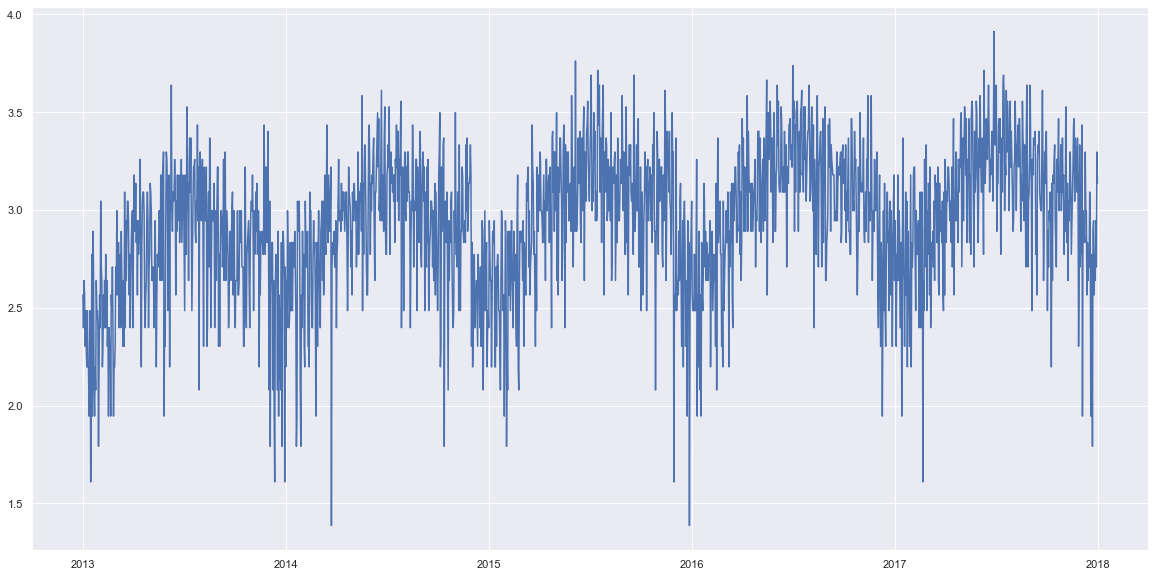

In [14]:
one_store['log_sales'] = np.log(one_store['sales'])
plt.plot(one_store['log_sales'])

# Dummies

In [15]:
first_one = df[(df.item==1)&(df.store==1)].copy()

In [16]:
first_one['month'] = first_one.index.month

In [17]:
month_dum = pd.get_dummies(first_one['month'])

In [18]:
month_dum.columns = ['month_dum-'+ str(w) for w in range(0,12)]

In [19]:
first_one = pd.concat([first_one, month_dum], axis=1)

In [20]:
first_one['dayofweek_dum'] = first_one.index.weekday

In [21]:
week_dummies = pd.get_dummies(first_one['dayofweek_dum'])

In [22]:
week_dummies.columns = ['dayofweek_dum-'+ str(w) for w in range(0,7)]

In [23]:
first_one = pd.concat([first_one, week_dummies], axis=1, join_axes=[first_one.index]).drop(['dayofweek_dum'],axis=1)

In [24]:
first_one['weekend'] = (first_one.index.dayofweek>4).astype(int)

In [25]:
data_r = pd.date_range(start='2013-01-01', end='2018-03-31')
cal = calendar()
holidays = cal.holidays(start=data_r.min(), end=data_r.max())
first_one['holyday'] = first_one.index.isin(holidays)
first_one['holyday'] = first_one['holyday']*1

# SARIMAX - time-series forecasting

In [26]:
train_start,train_end = '2015-01-01','2017-09-30'
test_start,test_end = '2017-10-01','2017-12-31'
train = first_one['sales'][train_start:train_end].dropna()
test =first_one['sales'][test_start:test_end].dropna()


In [27]:
ex_train = first_one.drop(['id','store','item','sales'],axis = 1)[train_start:train_end].dropna()
ex_test = first_one.drop(['id','store','item','sales'],axis = 1)[test_start:test_end].dropna()

In [28]:
train_sample = train.sample(frac=0.3, replace=True)

# Searching for the best pdq parameters

## Method 1

In [29]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


In [30]:
minimo=[]
minimo1=[]
minimo2=[]
for param in pdq:
     for param_seasonal in seasonal_pdq:
            try:
                mod1 = sm.tsa.statespace.SARIMAX(train_sample,
                                                order=param,
                                                seasonal_order=param_seasonal, 
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results1 = mod1.fit()
                print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results1.aic))
            except:
                continue
                
                          

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:2702.9317481436374
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:2440.916864026761
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:2143.270706849288
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:1911.794983725953
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:2138.9318716440716
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:1962.8839844173244
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:2016.5310686402886
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:1913.791015554551
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:2492.9706726208615
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:2338.2282238010057
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:2138.799057400518
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:1907.5148015737282
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:2140.742964517622
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:1959.2211255568543
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:2018.1942727977676
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:1909.5101949906523
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:2184.5070007765994
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:2140.5784007776265
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC

### the best parameter: ARIMA(1, 0, 1)x(0, 1, 1, 7)7 - AIC:1936.432206953986

In [31]:
results1= sm.tsa.statespace.SARIMAX(train,
                               order=(1,0,1),
                               seasonal_order=(0,1,1,7),
                               exog = ex_train,
                               freq='D',
                               enforce_stationarity=False, 
                               enforce_invertibility=False).fit()

print(results1.summary())

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1004
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2932.814
Date:                           Wed, 12 Jun 2019   AIC                           5917.628
Time:                                   11:44:23   BIC                           6044.916
Sample:                               01-01-2015   HQIC                          5966.034
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
month               0.3207      0.049      6.571      0.000       0.225       0.416
month_dum-0        -4.9590  

In [32]:
pred = results1.predict(train_end,test_end,exog = ex_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(test,pred)))

ARIMAX model MSE:22.13459187834565


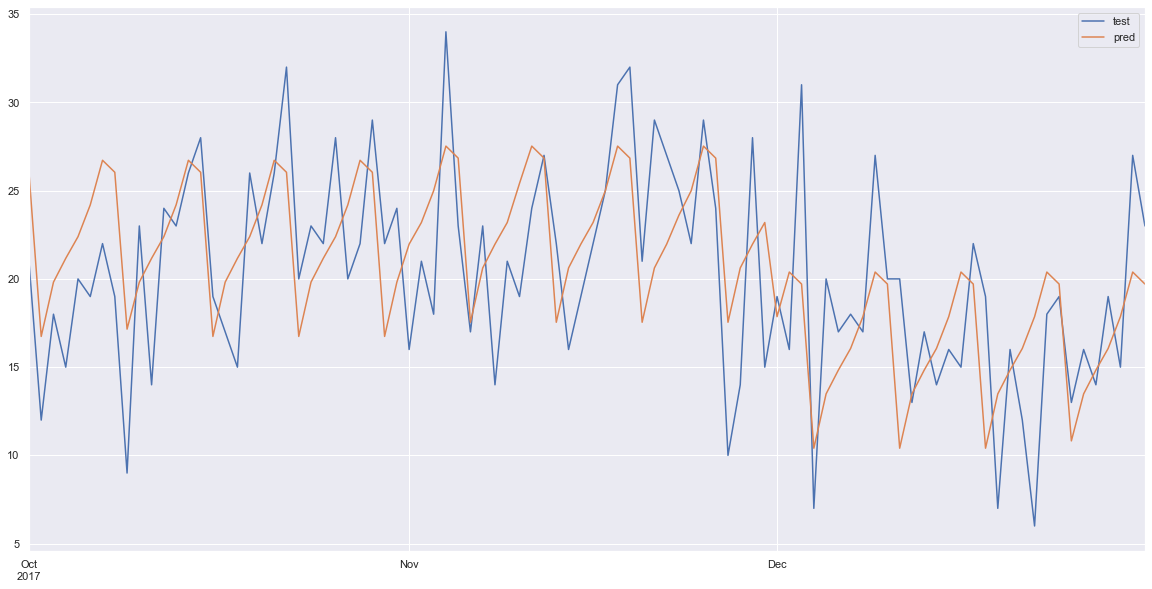

In [33]:
pd.DataFrame({'test':test,'pred':pred}).plot();plt.show()

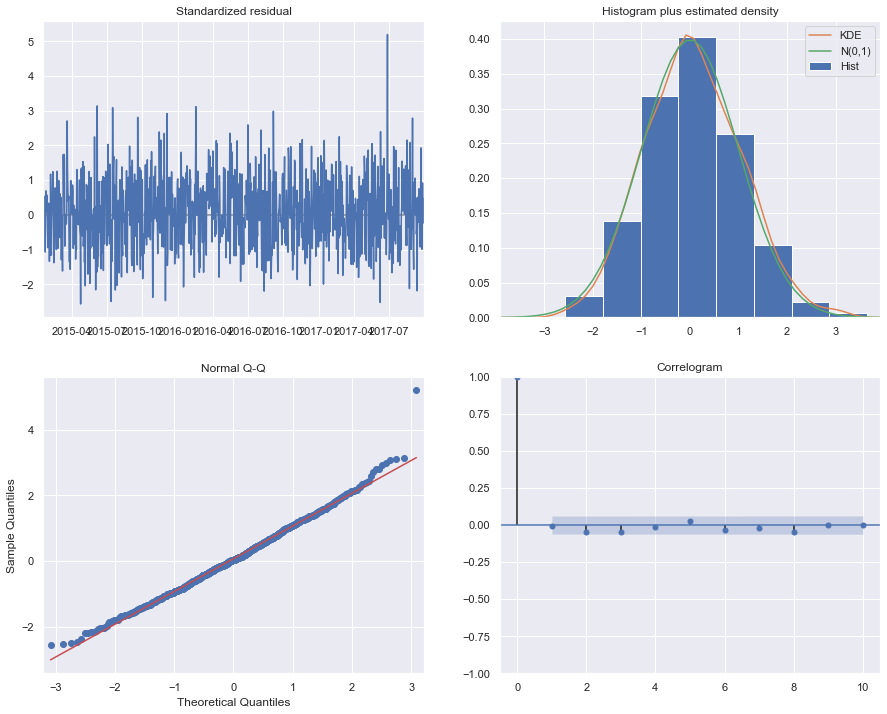

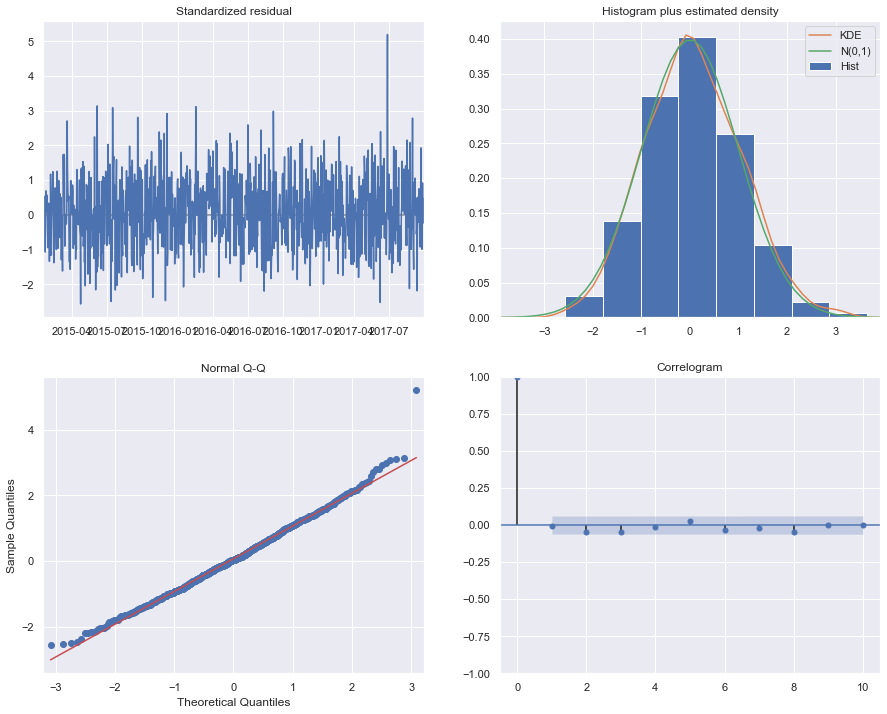

In [34]:
results1.plot_diagnostics(figsize=(15, 12))

## Method 2

In [35]:
searching_best = sm.tsa.arma_order_select_ic(train_sample, max_ar=7, max_ma=7, ic='aic', trend='c')
print('The bestpdq - ARMA(p,q) =',searching_best['aic_min_order'])

The bestpdq - ARMA(p,q) = (0, 3)


In [47]:
results2= sm.tsa.statespace.SARIMAX(train,
                               order=(0,0,3),
                               seasonal_order=(0,0,0,0),
                               exog = ex_train,
                               freq='D',
                               enforce_stationarity=False, 
                               enforce_invertibility=False).fit()

print(results2.summary())

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(0, 0, 3)   Log Likelihood               -3125.374
Date:                Wed, 12 Jun 2019   AIC                           6302.747
Time:                        11:52:21   BIC                           6430.349
Sample:                    01-01-2015   HQIC                          6351.245
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
month               2.5255      0.036     70.245      0.000       2.455       2.596
month_dum-0         8.2449      0.654     12.598      0.000       6.962       9.528
month_dum-1         8.6293      

In [48]:
pred = results2.predict(train_end,test_end,exog = ex_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(test,pred)))

ARIMAX model MSE:36.83596095414887


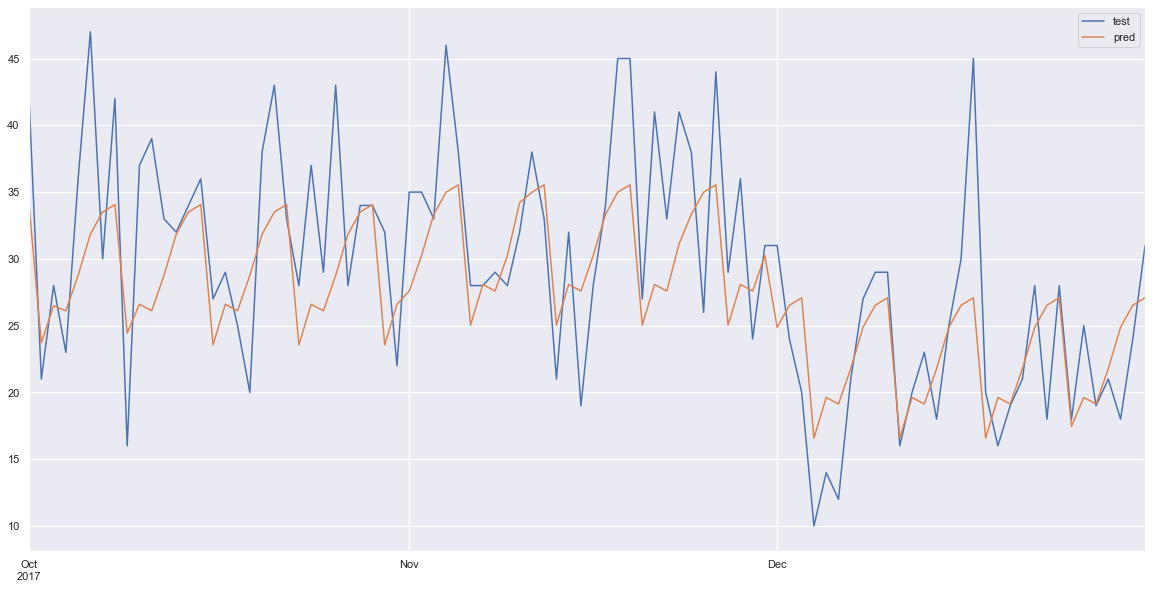

In [49]:
pd.DataFrame({'test':test,'pred':pred}).plot();plt.show()

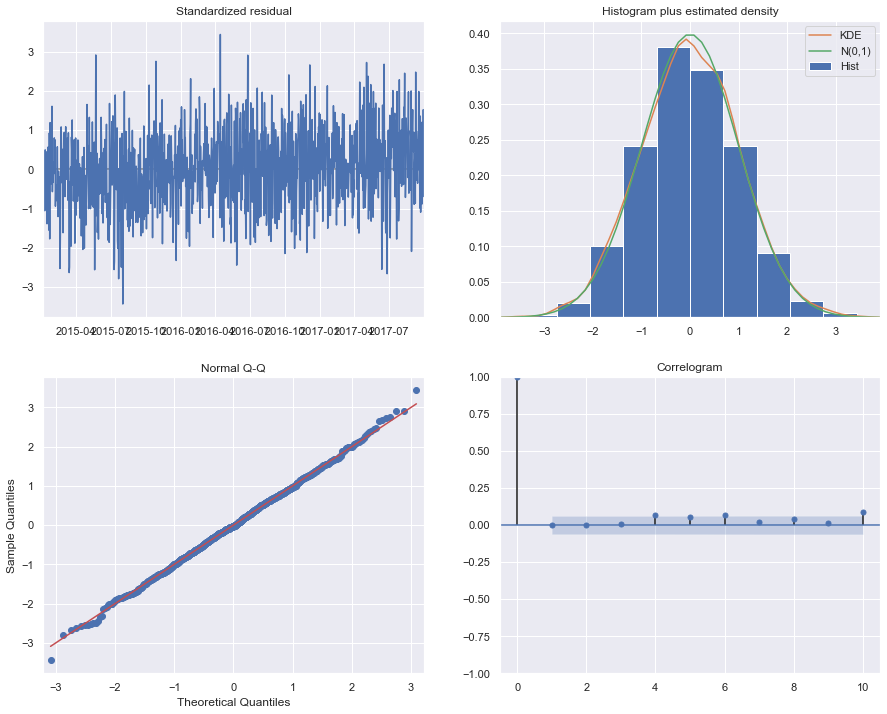

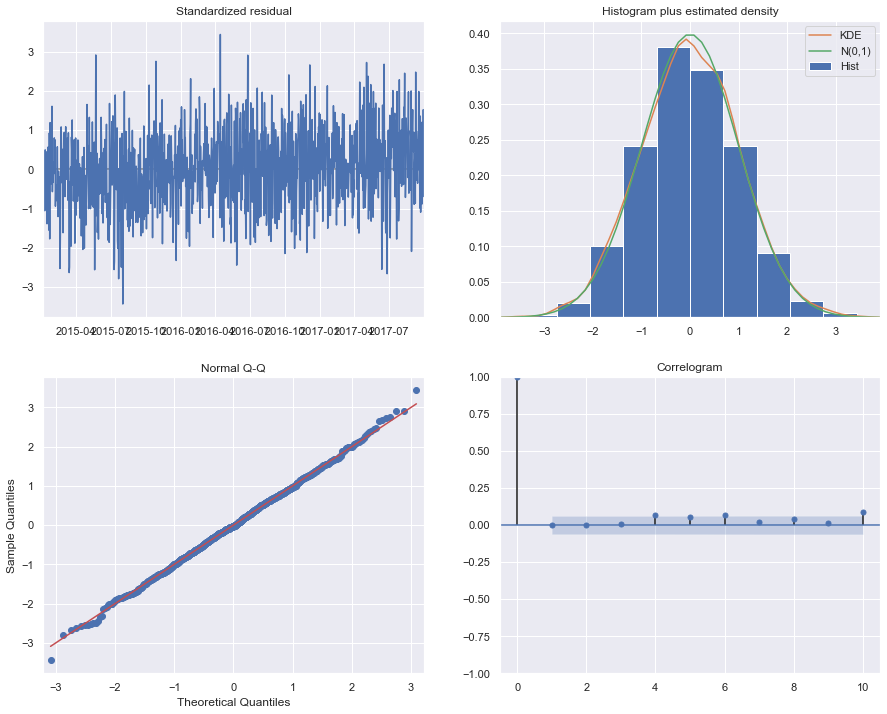

In [50]:
results2.plot_diagnostics(figsize=(15, 12))

# SUBMIT PREDICTION


In [40]:
#loading data
dfs_train = pd.read_csv("./Data/train.csv", parse_dates=['date'], index_col=['date'])
dfs_test = pd.read_csv("./Data/test.csv", parse_dates=['date'], index_col=['date'])
dfs = pd.concat([dfs_train,dfs_test],sort=True)

In [41]:
#loading data submission
subm = pd.read_csv('./Data/sample_submission.csv')

In [42]:
#changing nan
dfs = dfs.fillna(0)

In [43]:
#creating dummies
dfs['month'] = dfs.index.month
month_dum = pd.get_dummies(dfs['month'])
month_dum.columns = ['month_dum-'+ str(w) for w in range(0,12)]
dfs = pd.concat([dfs, month_dum], axis=1)
dfs['dayofweek_dum'] = dfs.index.weekday
week_dummies = pd.get_dummies(dfs['dayofweek_dum'])
week_dummies.columns = ['dayofweek_dum-'+ str(w) for w in range(0,7)]
dfs = pd.concat([dfs, week_dummies], axis=1, join_axes=[dfs.index]).drop(['dayofweek_dum'],axis=1)
dfs['weekend'] = (dfs.index.dayofweek>4).astype(int)

In [44]:
data_r = pd.date_range(start='2013-01-01', end='2018-03-31')
first_one['holyday'] = data_r
cal = calendar()
holidays = cal.holidays(start=data_r.min(), end=data_r.max())
first_one['holyday'] = first_one.index.isin(holidays)

In [45]:
#creating dummies holidays
date_r = pd.date_range(start='2013-01-01', end='2018-03-31')
#dfs['holyday'] = date_r
cal = calendar()
holidays = cal.holidays(start=date_r.min(), end=date_r.max())
dfs['holyday'] = dfs.index.isin(holidays)
dfs['holyday'] = dfs['holyday']*1

In [51]:
#the prediction
results = []

for w in range(1,51):
    for m in range(1,11):
        sales1 = dfs[(dfs.item==w)&(dfs.store==m)].copy()
        train_start,train_end = '2015-01-01','2017-09-30'
        test_start,test_end = '2017-10-01','2017-12-31'
        train = sales1['sales'][train_start:train_end]
        test =  sales1['sales'][test_start:test_end]
        ex_train = sales1.drop(['id','store','item','sales'],axis = 1)[train_start:train_end]
        ex_test = sales1.drop(['id','store','item','sales'],axis = 1)[test_start:test_end]
        target_exog = sales1[test_start:].drop(['id','store','item','sales'],axis = 1) 
        predict_mod = sm.tsa.statespace.SARIMAX(train,
                                                order=(0,0,3),
                                                seasonal_order=(0,1,1,7),
                                                exog = ex_train,
                                                freq='D',
                                                enforce_stationarity=False,
                                                enforce_invertibility=False).fit()
        predict_train = predict_mod.get_prediction(train_end,'2018-03-31', exog = target_exog)
        results.extend(predict_train.predicted_mean['2018-01-01':])
        print('item:',w,'store:',m,'Predicted.')      
        

item: 1 store: 1 Predicted.
item: 1 store: 2 Predicted.
item: 1 store: 3 Predicted.
item: 1 store: 4 Predicted.
item: 1 store: 5 Predicted.
item: 1 store: 6 Predicted.
item: 1 store: 7 Predicted.
item: 1 store: 8 Predicted.
item: 1 store: 9 Predicted.
item: 1 store: 10 Predicted.
item: 2 store: 1 Predicted.
item: 2 store: 2 Predicted.
item: 2 store: 3 Predicted.
item: 2 store: 4 Predicted.
item: 2 store: 5 Predicted.
item: 2 store: 6 Predicted.
item: 2 store: 7 Predicted.
item: 2 store: 8 Predicted.
item: 2 store: 9 Predicted.
item: 2 store: 10 Predicted.
item: 3 store: 1 Predicted.
item: 3 store: 2 Predicted.
item: 3 store: 3 Predicted.
item: 3 store: 4 Predicted.
item: 3 store: 5 Predicted.
item: 3 store: 6 Predicted.
item: 3 store: 7 Predicted.
item: 3 store: 8 Predicted.
item: 3 store: 9 Predicted.
item: 3 store: 10 Predicted.
item: 4 store: 1 Predicted.
item: 4 store: 2 Predicted.
item: 4 store: 3 Predicted.
item: 4 store: 4 Predicted.
item: 4 store: 5 Predicted.
item: 4 store: 6 

item: 29 store: 6 Predicted.
item: 29 store: 7 Predicted.
item: 29 store: 8 Predicted.
item: 29 store: 9 Predicted.
item: 29 store: 10 Predicted.
item: 30 store: 1 Predicted.
item: 30 store: 2 Predicted.
item: 30 store: 3 Predicted.
item: 30 store: 4 Predicted.
item: 30 store: 5 Predicted.
item: 30 store: 6 Predicted.
item: 30 store: 7 Predicted.
item: 30 store: 8 Predicted.
item: 30 store: 9 Predicted.
item: 30 store: 10 Predicted.
item: 31 store: 1 Predicted.
item: 31 store: 2 Predicted.
item: 31 store: 3 Predicted.
item: 31 store: 4 Predicted.
item: 31 store: 5 Predicted.
item: 31 store: 6 Predicted.
item: 31 store: 7 Predicted.
item: 31 store: 8 Predicted.
item: 31 store: 9 Predicted.
item: 31 store: 10 Predicted.
item: 32 store: 1 Predicted.
item: 32 store: 2 Predicted.
item: 32 store: 3 Predicted.
item: 32 store: 4 Predicted.
item: 32 store: 5 Predicted.
item: 32 store: 6 Predicted.
item: 32 store: 7 Predicted.
item: 32 store: 8 Predicted.
item: 32 store: 9 Predicted.
item: 32 st

In [55]:
subm['sales'] = results

In [56]:
subm.to_csv('submission.csv',index=False)